In [4]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout,Flatten
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

# Define paths
dataset_path = '/kaggle/input/dataset-alphabets/dataset'
train_dir = '/kaggle/working/dataset/train'
val_dir = '/kaggle/working/dataset/val'
test_dir = '/kaggle/working/dataset/test'

# Step 1: Create directories for train, val, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Assuming subfolders are labeled from A to Z
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    
    if os.path.isdir(label_path):  # Ensure it's a directory
        # Create subdirectories for this label (A-Z) in train, val, and test
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        os.makedirs(os.path.join(val_dir, label), exist_ok=True)
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)

        # Get all images for the label
        images = os.listdir(label_path)
        
        # Split data: 80% train, 10% val, 10% test
        train_data, val_test_data = train_test_split(images, test_size=0.2, random_state=42)
        val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)
        
        # Move files to respective directories
        for img in train_data:
            shutil.copy(os.path.join(label_path, img), os.path.join(train_dir, label, img))
        
        for img in val_data:
            shutil.copy(os.path.join(label_path, img), os.path.join(val_dir, label, img))
        
        for img in test_data:
            shutil.copy(os.path.join(label_path, img), os.path.join(test_dir, label, img))
batch_size=32

# Now, create ImageDataGenerators for these separate directories
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=batch_size, class_mode='categorical', shuffle=False)

# Sizes of datasets
print(f"Training Size: {train_generator.samples}")
print(f"Validation Size: {val_generator.samples}")
print(f"Test Size: {test_generator.samples}")


Found 25555 images belonging to 26 classes.
Found 3195 images belonging to 26 classes.
Found 3195 images belonging to 26 classes.
Training Size: 25555
Validation Size: 3195
Test Size: 3195


In [5]:
# Check the size of the training dataset
train_size = train_generator.n
print(f'Training Data Size: {train_size}')

# Check the size of the validation dataset
val_size = val_generator.n
print(f'Validation Data Size: {val_size}')

# Check the size of the test dataset
test_size = test_generator.n
print(f'Test Data Size: {test_size}')


Training Data Size: 25555
Validation Data Size: 3195
Test Data Size: 3195


In [7]:
from tensorflow.keras.layers import Flatten
# Number of classes
n_classes = 26  # Change this to the actual number of classes in your dataset

# Input tensor
input_tensor = Input(shape=(224, 224, 3))

# Base model with InceptionV3
base_model = MobileNetV3Large(include_top=False, input_tensor=input_tensor, weights='imagenet')

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Add a Dropout layer
x = Dropout(0.5)(x)

# Add a Dense layer
x = Dense(256, activation='relu')(x)

# Add another Dropout layer
x = Dropout(0.5)(x)

# Add another Dense layer
x = Dense(128, activation='relu')(x)

# Output layer
output = Dense(n_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:

for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 15,075,098 (57.51 MB)

 Trainable params: 12,078,746 (46.08 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729229045.418027     152 service.cc:145] XLA service 0x7eb644002250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729229045.418083     152 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/799 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.0398 - loss: 4.5604 

I0000 00:00:1729229054.633172     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


799/799 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.1045 - loss: 3.0252 - val_accuracy: 0.6457 - val_loss: 1.5581
Epoch 2/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.2540 - loss: 2.2843 - val_accuracy: 0.7662 - val_loss: 1.1716
Epoch 3/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.3268 - loss: 2.1026 - val_accuracy: 0.8019 - val_loss: 0.9830
Epoch 4/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.3695 - loss: 1.9676 - val_accuracy: 0.7477 - val_loss: 1.0566
Epoch 5/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.3843 - loss: 1.8926 - val_accuracy: 0.6767 - val_loss: 1.0207
Epoch 6/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.4002 - loss: 1.8509 - val_accuracy: 0.5465 - val_loss: 1.4119
Epoch 7/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.4088 - loss: 1.8160 - val_accuracy: 0.6197 - val_loss: 1.1484
Epoch 8/100
799/799 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.4314 - loss: 1.7310 - val_

In [ ]:
# After training the model
model.save('/kaggle/working/my_model.h5')  # Saves the model in HDF5 format


In [ ]:
import pickle

# Assuming `model` is your trained model
with open('/kaggle/working/my_model_InceptionV3.pickle', 'wb') as file:
    pickle.dump(model, file)


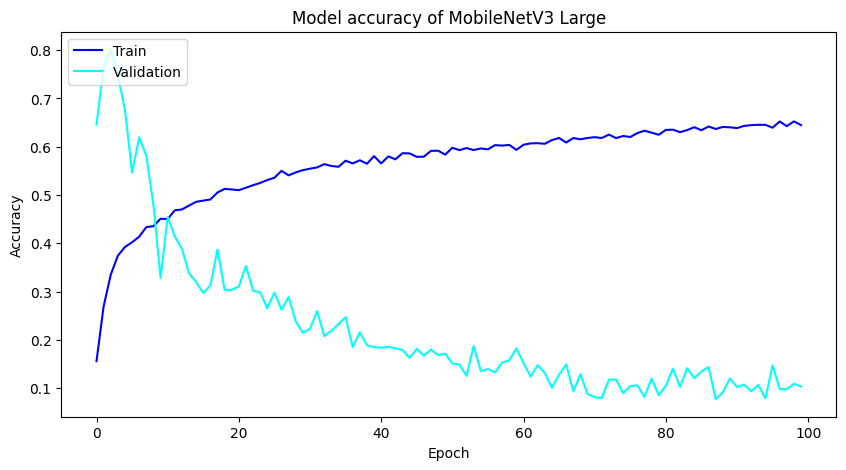

In [12]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(10, 5))


plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='cyan')
plt.title('Model accuracy of MobileNetV3 Large')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


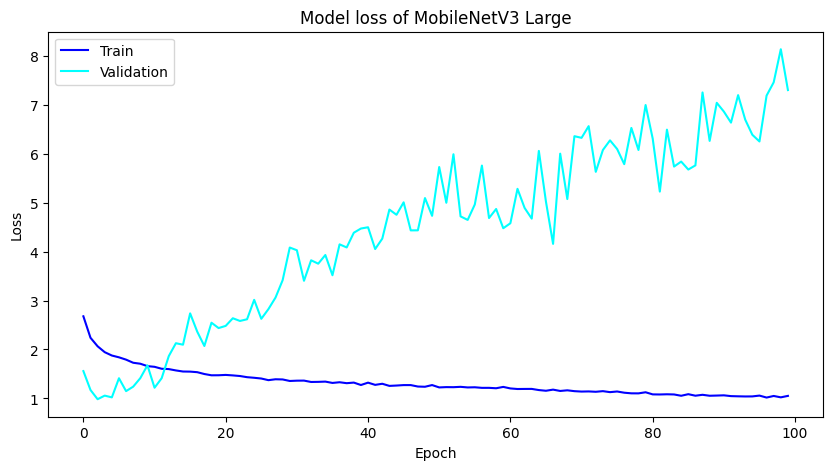

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='cyan')
plt.title('Model loss of MobileNetV3 Large')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [14]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
test_dir = '/kaggle/working/dataset/test'  # Your test directory path

# Parameters
batch_size = 32
image_size = (224, 224)

# Step 1: Create ImageDataGenerator for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalizing the data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' for 2 classes
    shuffle=False  # Set to False to avoid shuffling while predicting
)

# Initialize y_true list
y_true = []
# Check if test_generator has batches
if len(test_generator) > 0:
    for i in range(len(test_generator)):
        _, y = test_generator[i]
        y_true.append(np.argmax(y, axis=1))
else:
    raise ValueError("Test generator has no batches.")

# Check if y_true is populated
if not y_true:
    raise ValueError("y_true is empty. Check the test_generator output.")

y_true = np.concatenate(y_true)

# Get predicted labels
y_pred_classes = np.argmax(model.predict(test_generator, steps=len(test_generator)), axis=1)

# Ensure lengths match
if len(y_true) != len(y_pred_classes):
    raise ValueError(f"Length mismatch: y_true({len(y_true)}), y_pred_classes({len(y_pred_classes)})")

# Compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

# Calculate the number of correct predictions
correct_predictions = np.sum(y_pred_classes == y_true)

# Calculate the total number of predictions
total_predictions = len(y_true)

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

print(f'Test Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')


Found 3195 images belonging to 26 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step
Test Accuracy: 0.11
Precision: 0.07
Recall: 0.11
F1 Score: 0.06


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.15      0.99      0.26       120
           2       0.00      0.00      0.00       145
           3       0.00      0.00      0.00       120
           4       0.38      1.00      0.55       120
           5       0.29      0.68      0.41       120
           6       0.00      0.00      0.00       120
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00       138
           9       0.00      0.00      0.00       120
          10       0.00      0.00      0.00       120
          11       0.96      0.21      0.34       120
          12       0.00      0.00      0.00       120
          13       0.00      0.00      0.00       120
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       120
          16       0.00      0.00      0.00       120
          17       0.00    

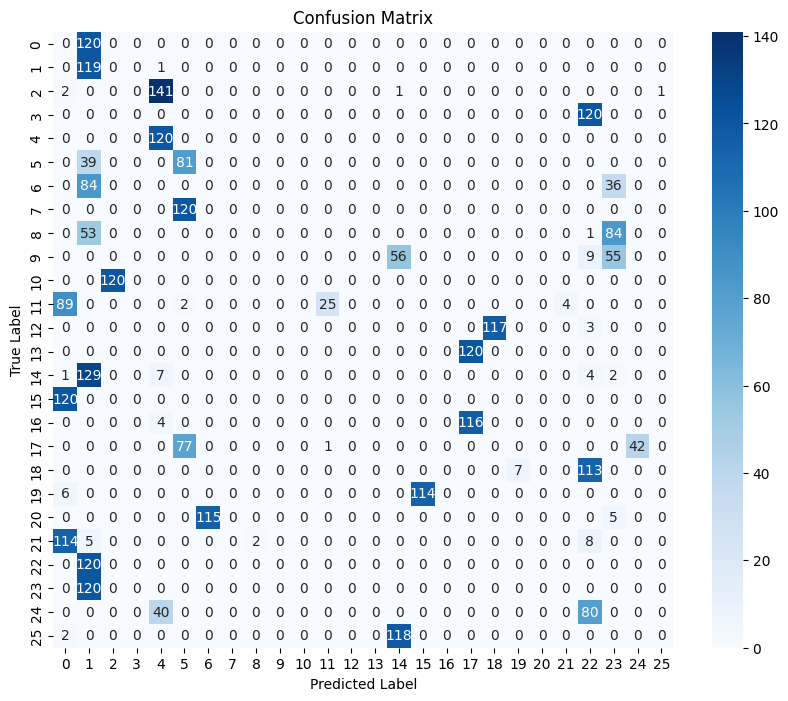

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming n_classes is set to the correct number of classes (24 in this case)
n_classes = 26

# Ensure target_names matches the number of classes
target_names = [str(i) for i in range(n_classes)]

# Display classification report
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
